In [6]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import linregress
import os

In [2]:
def calculate_linear_trend_spat_pattern(file_path, variable, output_file):
    # Open dataset and extract variable
    ds = xr.open_dataset(file_path)
    da = ds[variable]

    time = ds['year'].values
    lat = ds['lat'].values
    lon = ds['lon'].values
    time_numeric = np.arange(len(time))

    slope = np.full((len(lat), len(lon)), np.nan)
    intercept = np.full((len(lat), len(lon)), np.nan)
    p_value = np.full((len(lat), len(lon)), np.nan)
    stderr = np.full((len(lat), len(lon)), np.nan)

    for i in range(len(lat)):
        for j in range(len(lon)):
            ts = da[:, i, j].values
            if np.all(np.isfinite(ts)):
                reg = linregress(time_numeric, ts)
                slope[i, j] = reg.slope
                intercept[i, j] = reg.intercept
                p_value[i, j] = reg.pvalue
                stderr[i, j] = reg.stderr

    from scipy.stats import t
    n = len(time_numeric)
    df = n - 2
    alpha = 0.05
    t_crit = t.ppf(1 - alpha/2, df)

    ci_lower = slope - t_crit * stderr
    ci_upper = slope + t_crit * stderr

    slope_da = xr.DataArray(slope, coords=[lat, lon], dims=["lat", "lon"], name="slope")
    intercept_da = xr.DataArray(intercept, coords=[lat, lon], dims=["lat", "lon"], name="intercept")
    p_value_da = xr.DataArray(p_value, coords=[lat, lon], dims=["lat", "lon"], name="p_value")
    ci_lower_da = xr.DataArray(ci_lower, coords=[lat, lon], dims=["lat", "lon"], name="slope_CI_lower")
    ci_upper_da = xr.DataArray(ci_upper, coords=[lat, lon], dims=["lat", "lon"], name="slope_CI_upper")

    # Save to one combined netCDF file
    combined_ds = xr.Dataset({
        "slope": slope_da,
        "intercept": intercept_da,
        "p_value": p_value_da,
        "slope_CI_lower": ci_lower_da,
        "slope_CI_upper": ci_upper_da
    })

    #combined_ds.to_netcdf(output_file)
    #print('saved')

    return slope_da, p_value_da, ci_lower_da, ci_upper_da



In [4]:
variable = 'psl'
experiment = ['historical','hist-aer','hist-GHG', 'hist-sol','hist-totalO3','hist-volc']
model = ['CanESM5']
period = ['1850-2015']
#would need to like recalculate the ensemble means for that time period too?

for e in experiment:
    print('calculating the linear trend for experiment: ', e)

    for m in model:
        print('Model: ', m)
        for p in period:
            print('Period: ', p)
            folder_path = '/gws/nopw/j04/extant/users/slbennie/ens_mean_spat/psl/'+e+'/'+m+'/'
            file_path = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if 'DJF' in filename and p in filename][0]
            output_file = '/gws/nopw/j04/extant/users/slbennie/trend_calc_LESFMIP/linear_regression/NAO/'+e+'/'+m+'/'+variable+'_mon_'+e+'_'+m+'_DJF_linear_trend_'+p+'_stats.nc'
    
            slope_da, p_value_da, ci_lower_da, ci_upper_da = calculate_linear_trend_spat_pattern(file_path, variable, output_file)

calculating the linear trend for experiment:  historical
Model:  CanESM5
Period:  1850-2015
calculating the linear trend for experiment:  hist-aer
Model:  CanESM5
Period:  1850-2015
calculating the linear trend for experiment:  hist-GHG
Model:  CanESM5
Period:  1850-2015
calculating the linear trend for experiment:  hist-sol
Model:  CanESM5
Period:  1850-2015
calculating the linear trend for experiment:  hist-totalO3
Model:  CanESM5
Period:  1850-2015
calculating the linear trend for experiment:  hist-volc
Model:  CanESM5
Period:  1850-2015


/tmp/ipykernel_575/2666762379.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 0.91, 0.97])


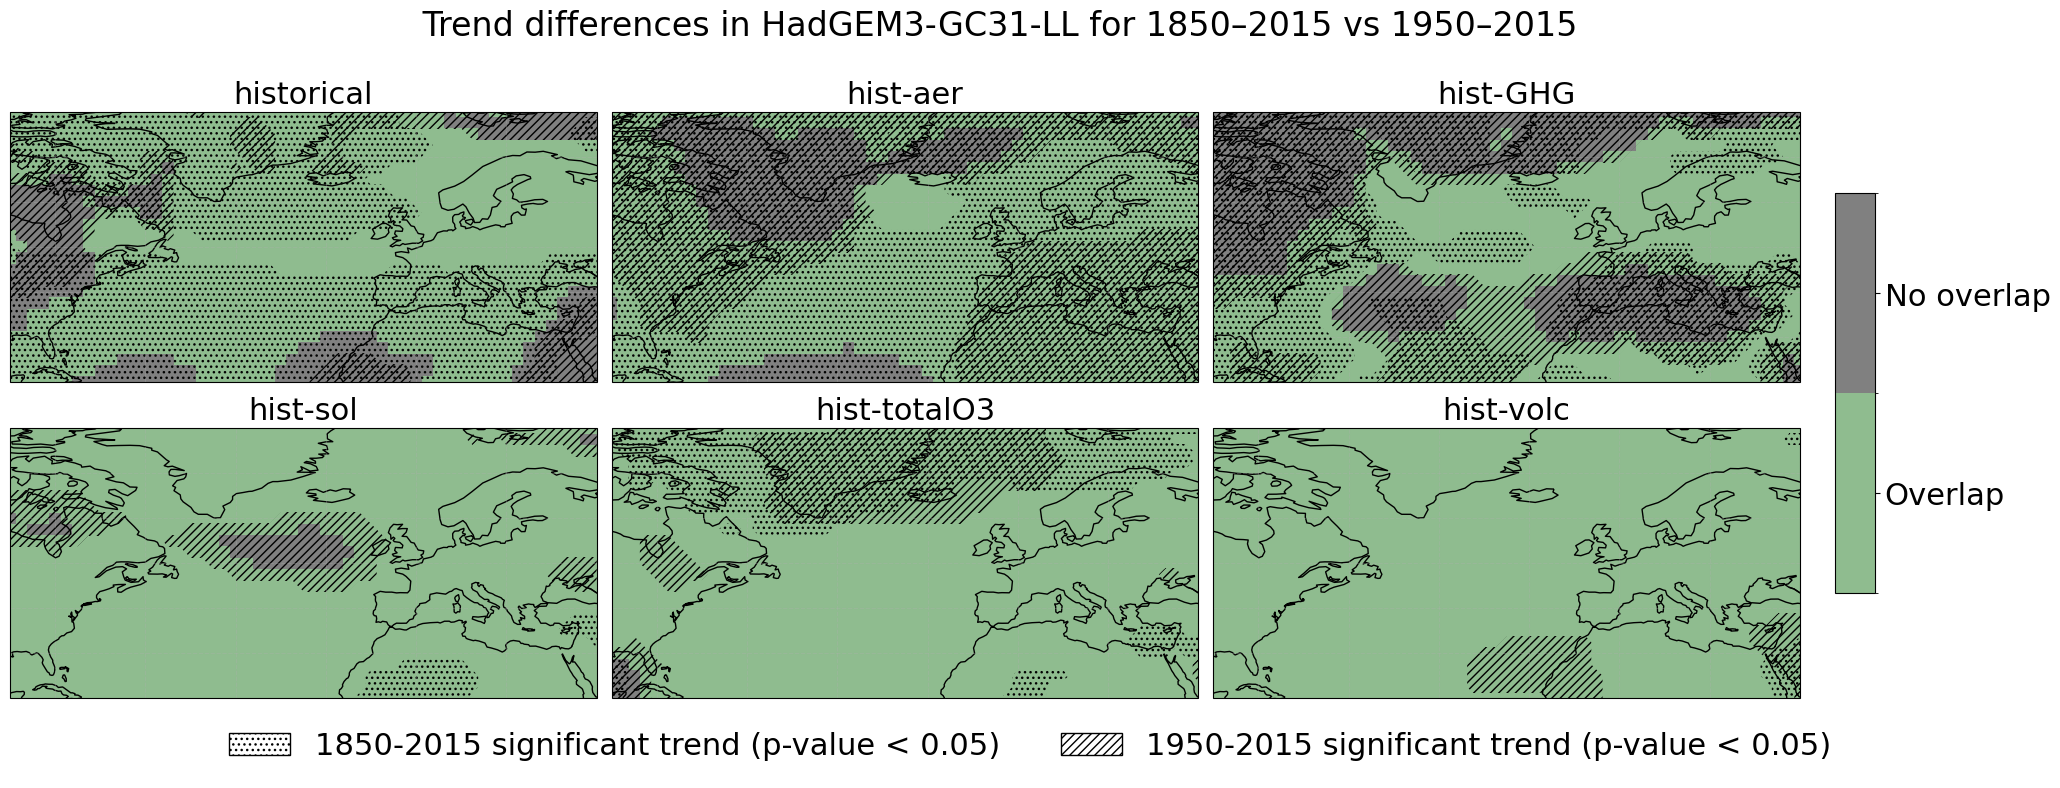

In [40]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=(20,8), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

# Custom colors for False (overlap), True (no overlap)
cmap = mcolors.ListedColormap(['darkseagreen', 'grey'])
bounds = [0, 0.5, 1]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

lat_range = slice(20, 80)
lon_range = slice(-90, 40)

experiment = ['historical','hist-aer','hist-GHG', 'hist-sol','hist-totalO3','hist-volc']
m = 'HadGEM3-GC31-LL'

#basically can give an indes whilts going through each experiment
for i, e in enumerate(experiment):
    ds1 = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/trend_calc_LESFMIP/linear_regression/NAO/'+e+'/'+m+'/psl_mon_'+e+'_'+m+'_DJF_linear_trend_1850-2015_stats.nc').sel(lat=lat_range, lon=lon_range)
    ds2 = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/trend_calc_LESFMIP/linear_regression/NAO/'+e+'/'+m+'/psl_mon_'+e+'_'+m+'_DJF_linear_trend_1950-2015_stats.nc').sel(lat=lat_range, lon=lon_range)
    
    ci_upper1 = ds1['slope_CI_upper']
    ci_upper2 = ds2['slope_CI_upper']
    ci_lower1 = ds1['slope_CI_lower']
    ci_lower2 = ds2['slope_CI_lower']
    
    mask = (ci_upper1 < ci_lower2)|(ci_upper2 < ci_lower1)


    ax = axes[i]

    #creates a mask to find TRUE = no overlap, FALSE = overlap between the confidience intervals of the 2 trend periods
    mask.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False)

    #creating the stipling/hatching for the significance of indiviual trends
    #basically where the trends are not zero
    #need to get some significance masks
    sig1 = ds1['p_value'] < 0.05
    sig2 = ds2['p_value'] < 0.05

    # /// diagonal hatching, xxx cross hatching
    ax.contourf(ds1['lon'], ds1['lat'], sig1, levels=[0.5,1], colors='none', hatches=['...'], transform=ccrs.PlateCarree(), alpha=0)
    ax.contourf(ds2['lon'], ds2['lat'], sig2, levels=[0.5,1], colors='none', hatches=['////'], transform=ccrs.PlateCarree(), alpha=0)
    
    ax.coastlines()
    ax.set_xlabel('lon')
    ax.set_ylabel('lat')
    ax.set_title(e, fontsize=22)
    ax.set_extent([lon_range.start, lon_range.stop, lat_range.start, lat_range.stop], crs=ccrs.PlateCarree())
    ax.gridlines(linestyle='--', alpha=0.3)
    ax.set_aspect('auto')  
    
# Create custom legend handles for the hatches
patch1 = mpatches.Patch(facecolor='white', edgecolor='black', hatch='...', label='1850-2015 significant trend (p-value < 0.05)')
patch2 = mpatches.Patch(facecolor='white', edgecolor='black', hatch='////', label='1950-2015 significant trend (p-value < 0.05)')

fig.legend(handles=[patch1, patch2], loc='lower center', ncol=2, fontsize=22, frameon=False)

# Add a shared colorbar
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax, ticks=[0.25, 0.75])
cbar.ax.set_yticklabels(['Overlap', 'No overlap'], fontsize=22)
    
plt.suptitle(" Trend differences in " + m + " for 1850–2015 vs 1950–2015", fontsize=24)
plt.savefig(f'Trend_differences_significance_{m}.png', bbox_inches='tight')
plt.tight_layout(rect=[0, 0.1, 0.91, 0.97])
plt.show()

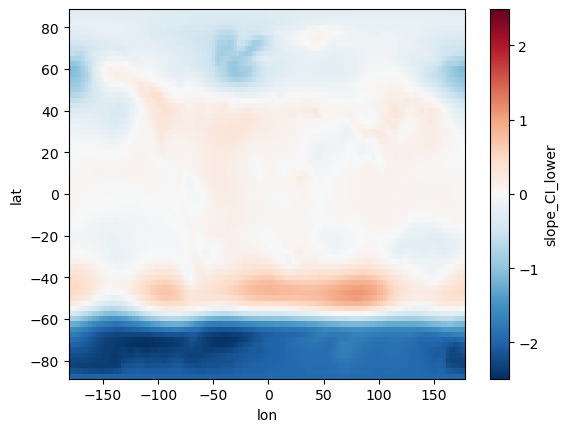

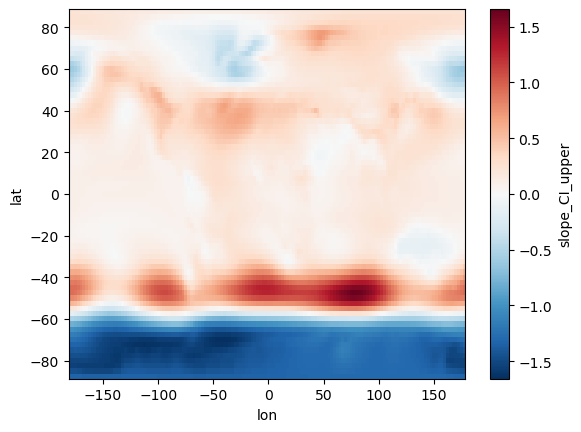

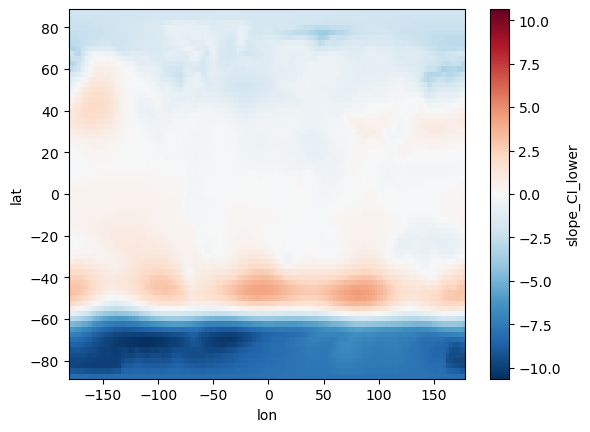

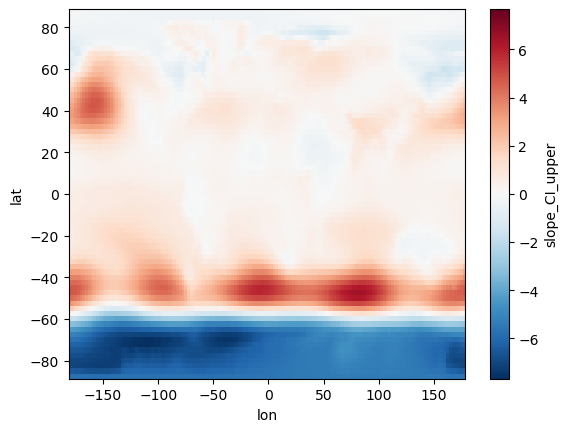

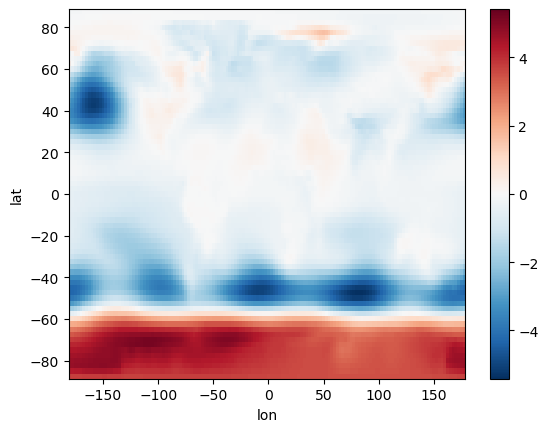

In [9]:
ci_lower_da.plot()
plt.show()
ci_upper_da.plot()
plt.show()
ci_lower_da2.plot()
plt.show()
ci_upper_da2.plot()
plt.show()
(ci_lower_da - ci_upper_da2).plot()
plt.show()

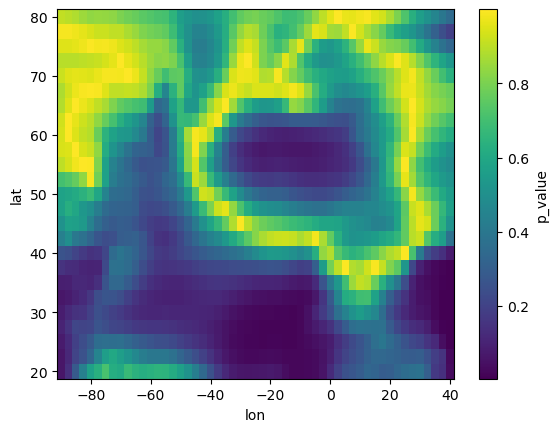

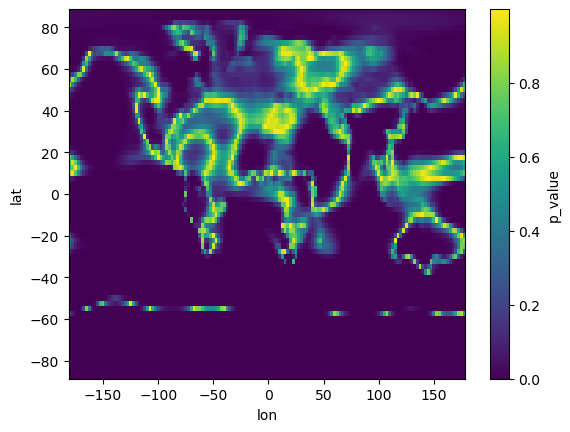

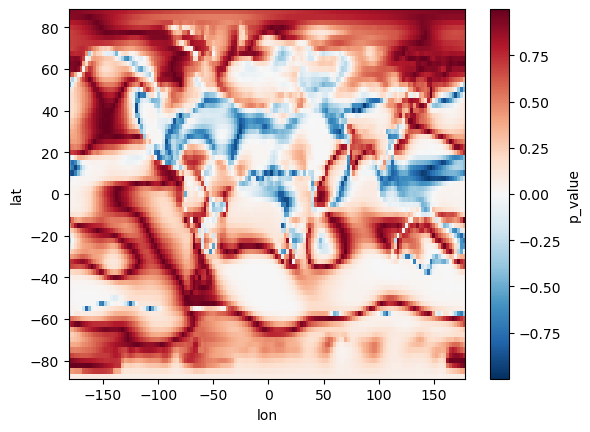

In [42]:
p_value_da.sel(lat=lat_range, lon=lon_range).plot()
plt.show()
p_value_da2.plot()
plt.show()
(p_value_da-p_value_da2).plot()
plt.show()

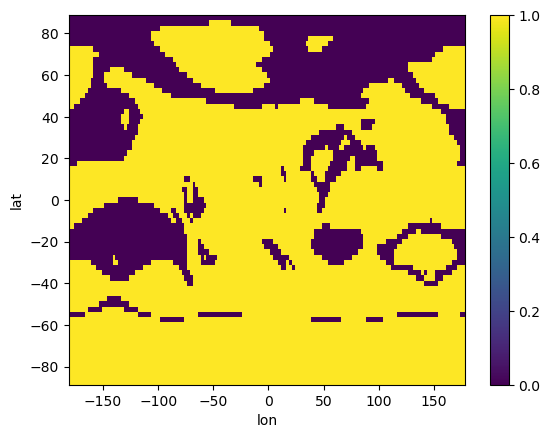

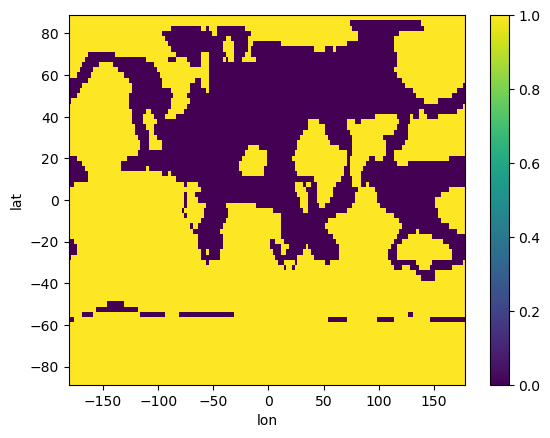

In [32]:
significant_mask = (ci_lower_da > 0) | (ci_upper_da < 0)
significant_mask.plot()
plt.show()
significant_mask2 = (ci_lower_da2 > 0) | (ci_upper_da2 < 0)
significant_mask2.plot()
plt.show()

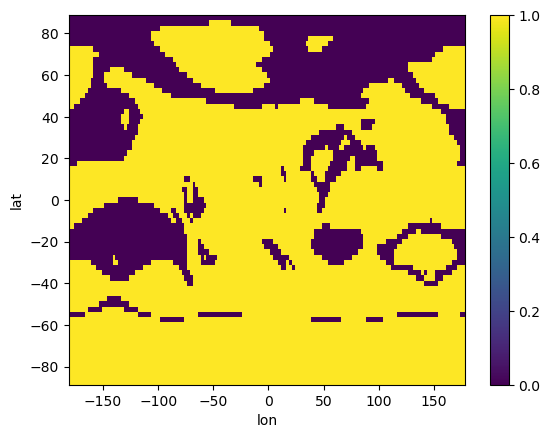

In [25]:
significant_mask2 = (ci_lower_da2 > 0) | (ci_upper_da2 < 0)
significant_mask2.plot()

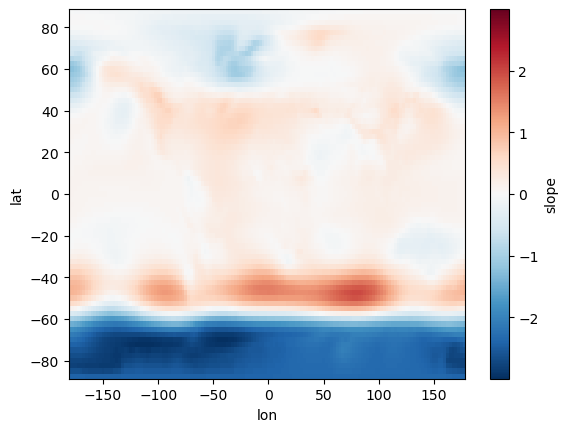

In [24]:
linear_regression = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/trend_calc_LESFMIP/linear_regression/NAO/historical/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_DJF_linear_trend.nc')
#linear_regression['slope'].plot()
(linear_regression['slope']*1.45).plot()